This is a study of workflows used in patrolling, for me to learn about the job of patrolling, the tools of the trade and how they are used.

Generate a TSV of API actions during a time window:

```sql
SELECT
  userAgent, wiki, params
FROM
  wmf_raw.ApiAction
WHERE year = 2018
  AND month = 6
  AND day = 20
  AND hadError = false
  AND
    (params['action'] = 'patrol')
;
```

    beeline -f api_patrolling.sql > patrolling_WINDOW.tsv

As you can see, this information is sensitive, so I won't upload it to source control:

```
useragent            wiki    params
Mozilla/[redacted]   frwiki  {"formatversion":"2","format":"json","action":"patrol","rcid":"148019620","token":"[redacted]"}
Mozilla/[redacted]   enwiki  {"formatversion":"2","format":"json","action":"patrol","rcid":"1064204306","token":"[redacted]"}
```

In [1]:
from collections import Counter
import csv
import json
import re
import yaml

with open("config.yaml") as f:
    config = yaml.safe_load(f)

ua_family_log = []
target_type_log = []
tags_log = []
with open("patrolling_hour.tsv", "r") as f:
    api_actions = csv.DictReader(f, dialect='excel-tab')

    for line in api_actions:
        if line["params"] is not None:
            line["params"] = json.loads(line["params"])
        else:
            line["params"] = {}

        no_hits = True
        
        for rule in config["rules"]:
            hit = False
            
            if "ua_re" in rule:
                if re.search(rule["ua_re"], line["useragent"]):
                    hit = True
            
            if hit:
                action = rule["action"]
                no_hits = False
                if "ua_family" in action:
                    ua_family_log.append(action["ua_family"])
        
        if no_hits:
            print(line)
    
        if "revid" in line["params"]:
            target_type_log.append("revision")
        elif "rcid" in line["params"]:
            target_type_log.append("recent change")
        
        if "tags" in line["params"]:
            tags_log.append(line["params"]["tags"])

In [2]:
counts = Counter(ua_family_log).most_common()

counts

[('browser', 11064),
 ('bot-patrol', 1111),
 ('bot-127', 186),
 ('tool-Twinkle', 80),
 ('bot-Dungodung', 30),
 ('bot-wm-antivandal-daemon', 5),
 ('tool-morebits', 5),
 ('bot-mooc', 2)]

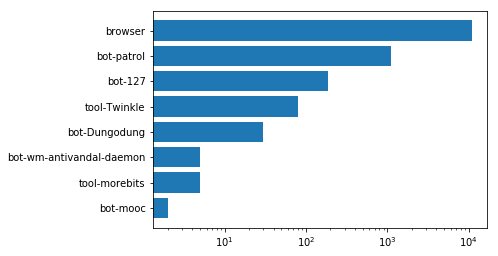

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
    log=True
)
plt.show()

In [4]:
counts = Counter(target_type_log).most_common()

counts

[('recent change', 10469), ('revision', 1929)]

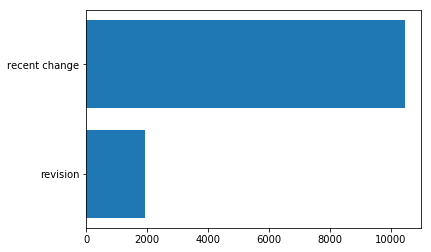

In [5]:
pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()

In [6]:
counts = Counter(tags_log).most_common()

counts

[]

Nobody uses the `tags` parameter!  This is worth filing a bug to either remove it from the API, or publicize its existence.

Now, let's look at the raw requests for more clues.

```sql
SELECT
  uri_query, uri_host, referer, user_agent, referer_class
FROM
  wmf.webrequest
WHERE year = 2018
  AND month = 6
  AND day = 20
  AND agent_type = 'user'
  AND
    parse_url(concat('http://foo/', uri_query), 'QUERY', 'action') = 'patrol'
;
```

In [15]:
with open("patrolling_requests.tsv", "r") as f:
    requests = csv.DictReader(f, dialect='excel-tab')

    referer_log = []
    for line in requests:
        if line["referer"] is not None:
            if re.search("Special(:|%3A)RecentChanges", line["referer"]):
                referer_log.append("RecentChanges")
            elif re.search("Special(:|%3A)Contributions", line["referer"]):
                referer_log.append("Contributions")
            elif re.search("Special(:|%3A)Watchlist", line["referer"]):
                referer_log.append("Watchlist")
            elif re.search(":LiveRC", line["referer"]):
                referer_log.append("LiveRC")
            else:
                print(line["referer"])

-
-


In [16]:
counts = Counter(referer_log).most_common()

counts

[('Contributions', 164),
 ('RecentChanges', 104),
 ('LiveRC', 69),
 ('Watchlist', 11)]

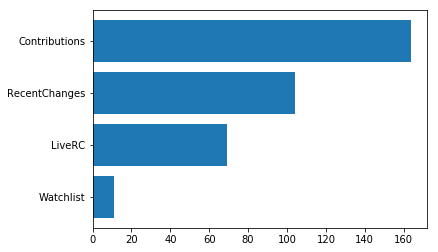

In [17]:
pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()